Objective:
The objective of this assignment is to compare the performance of Light GBM and XG Boost algorithms using the Titanic dataset. 
Exploratory Data Analysis (EDA):
1.	Load the Titanic dataset using Python's pandas library.
2.	Check for missing values.
3.	Explore data distributions using histograms and box plots.
4.	Visualize relationships between features and survival using scatter plots and bar plots.
Data Preprocessing:
1.	Impute missing values.
2.	Encode categorical variables using one-hot encoding or label encoding. 
3.	If needed you can apply more preprocessing methods on the given dataset.
Building Predictive Models:
1.	Split the preprocessed dataset into training and testing sets.
2.	Choose appropriate evaluation metrics (e.g., accuracy, precision, recall, F1-score) for model evaluation.
3.	Build predictive models using LightGBM and XGBoost algorithms.
4.	Train the models on the training set and evaluate their performance on the testing set.
5.	Use techniques like cross-validation and hyperparameter tuning to optimize model performance.
Comparative Analysis:
1.	Compare the performance metrics (e.g., accuracy, precision, recall) of LightGBM and XGBoost models.
2.	Visualize and interpret the results to identify the strengths and weaknesses of each algorithm.


Train Dataset Missing Values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Test Dataset Missing Values:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


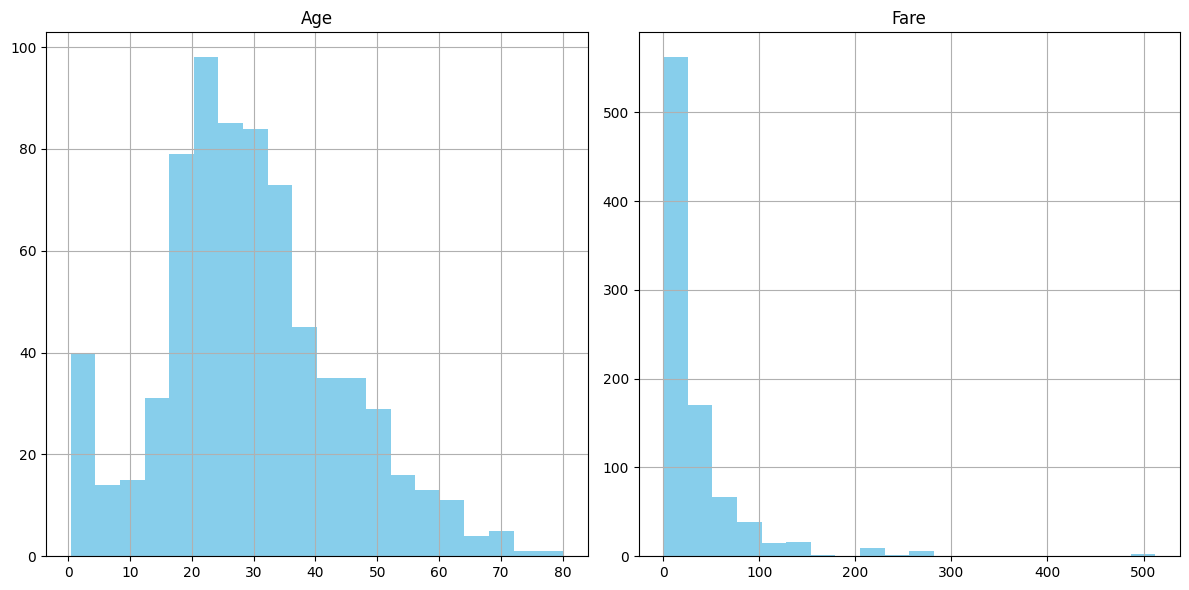

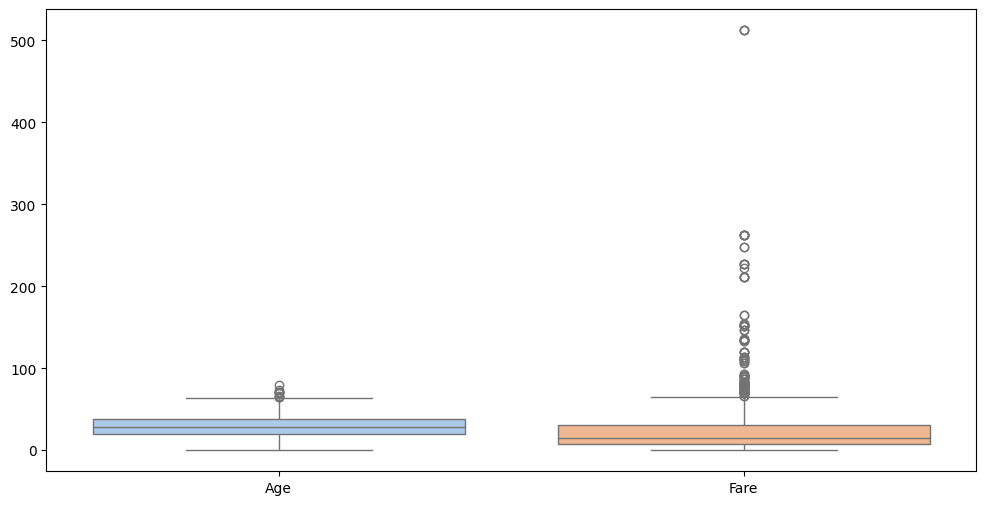

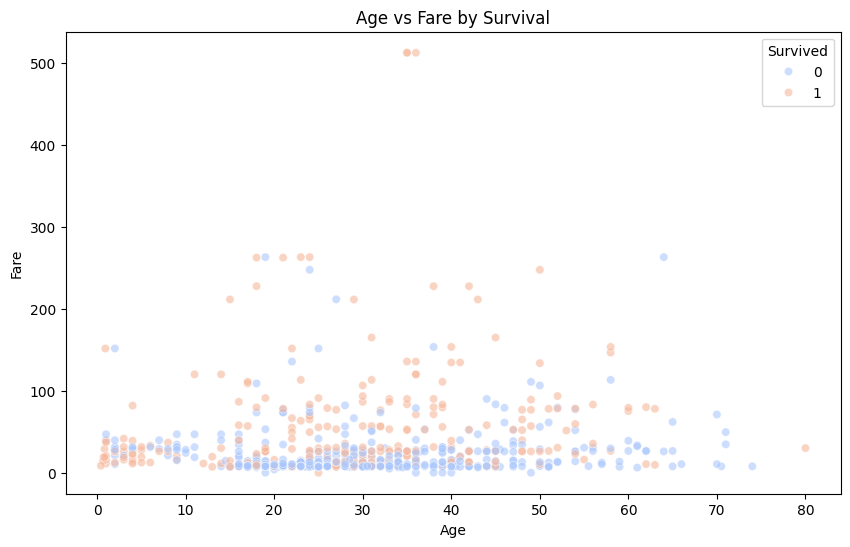

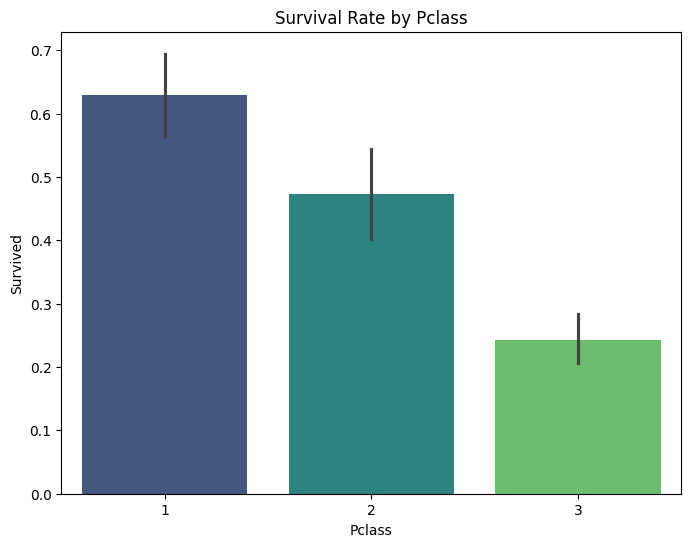

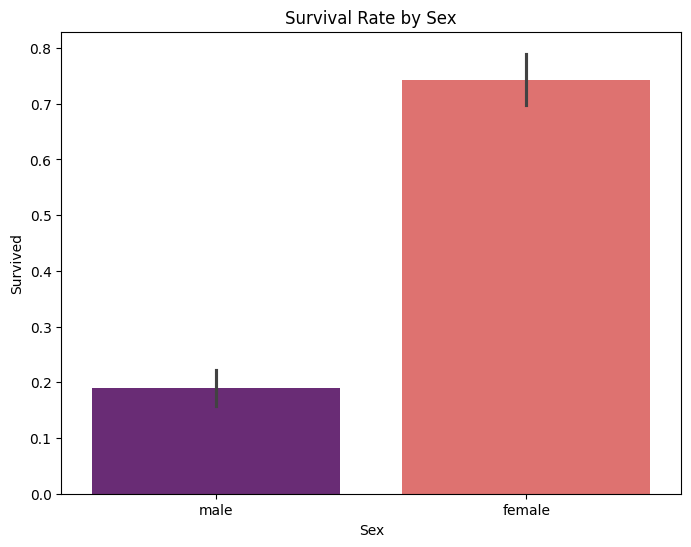

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import warnings
# Ignore warnings
warnings.filterwarnings("ignore")
# Load datasets
train_df = pd.read_csv(r"C:\Users\Dell\Downloads\Titanic_train.csv")
test_df = pd.read_csv(r"C:\Users\Dell\Downloads\Titanic_test.csv")

# Check for missing values
print("Train Dataset Missing Values:\n", train_df.isnull().sum())
print("\nTest Dataset Missing Values:\n", test_df.isnull().sum())

# Histograms for numerical features
train_df.hist(['Age', 'Fare'], bins=20, figsize=(12, 6), color='skyblue')
plt.tight_layout()
plt.show()

# Box plots for numerical features
plt.figure(figsize=(12, 6))
sns.boxplot(data=train_df[['Age', 'Fare']], palette='pastel')
plt.show()

# Scatter plot of Age vs Fare colored by Survival
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_df, x='Age', y='Fare', hue='Survived', palette='coolwarm', alpha=0.6)
plt.title('Age vs Fare by Survival')
plt.show()

# Bar plot of Survival by Pclass
plt.figure(figsize=(8, 6))
sns.barplot(x='Pclass', y='Survived', data=train_df, palette='viridis')
plt.title('Survival Rate by Pclass')
plt.show()

# Bar plot of Survival by Sex
plt.figure(figsize=(8, 6))
sns.barplot(x='Sex', y='Survived', data=train_df, palette='magma')
plt.title('Survival Rate by Sex')
plt.show()


In [2]:
# Impute missing values
imputer_age = SimpleImputer(strategy='median')
train_df['Age'] = imputer_age.fit_transform(train_df[['Age']])
test_df['Age'] = imputer_age.transform(test_df[['Age']])

imputer_embarked = SimpleImputer(strategy='most_frequent')
train_df['Embarked'] = imputer_embarked.fit_transform(train_df[['Embarked']])
test_df['Embarked'] = imputer_embarked.transform(test_df[['Embarked']])

# Drop Cabin due to too many missing values
train_df = train_df.drop(columns=['Cabin'])
test_df = test_df.drop(columns=['Cabin'])

# Encode categorical variables
encoder = OneHotEncoder(sparse=False, drop='first')
train_encoded = encoder.fit_transform(train_df[['Sex', 'Embarked']])
test_encoded = encoder.transform(test_df[['Sex', 'Embarked']])

# Create DataFrames from the encoded features
train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(['Sex', 'Embarked']))
test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(['Sex', 'Embarked']))

# Merge encoded features with original data
train_df = train_df.join(train_encoded_df).drop(columns=['Sex', 'Embarked'])
test_df = test_df.join(test_encoded_df).drop(columns=['Sex', 'Embarked'])

# Display the first few rows of the processed train dataset
print(train_df.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  38.0      1      0   
2                             Heikkinen, Miss. Laina  26.0      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  35.0      1      0   
4                           Allen, Mr. William Henry  35.0      0      0   

             Ticket     Fare  Sex_male  Embarked_Q  Embarked_S  
0         A/5 21171   7.2500       1.0         0.0         1.0  
1          PC 17599  71.2833       0.0         0.0         0.0  
2  STON/O2. 3101282   7.9250       0.0         0.0         1.0  
3            113803  53.1000       0.0         0.0         1.0  
4

In [3]:

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb
import xgboost as xgb


# Features and target
X = train_df.drop(columns=['Survived', 'Name', 'Ticket', 'PassengerId'])
y = train_df['Survived']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Evaluation metrics
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')

# LightGBM model
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)
print("LightGBM Model Performance:")
evaluate_model(lgb_model, X_test, y_test)

# XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
print("\nXGBoost Model Performance:")
evaluate_model(xgb_model, X_test, y_test)

# Cross-validation
lgb_cv_scores = cross_val_score(lgb_model, X_train, y_train, cv=5, scoring='accuracy')
xgb_cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nLightGBM CV Accuracy: {lgb_cv_scores.mean():.4f}")
print(f"XGBoost CV Accuracy: {xgb_cv_scores.mean():.4f}")

# Hyperparameter tuning for LightGBM
lgb_param_grid = {
    'num_leaves': [31, 50],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200]
}
lgb_grid = GridSearchCV(lgb.LGBMClassifier(), lgb_param_grid, cv=5, scoring='accuracy')
lgb_grid.fit(X_train, y_train)
print("\nBest LightGBM Parameters:", lgb_grid.best_params_)

# Hyperparameter tuning for XGBoost
xgb_param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200]
}
xgb_grid = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgb_param_grid, cv=5, scoring='accuracy')
xgb_grid.fit(X_train, y_train)
print("Best XGBoost Parameters:", xgb_grid.best_params_)


[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000763 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 195
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 195
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


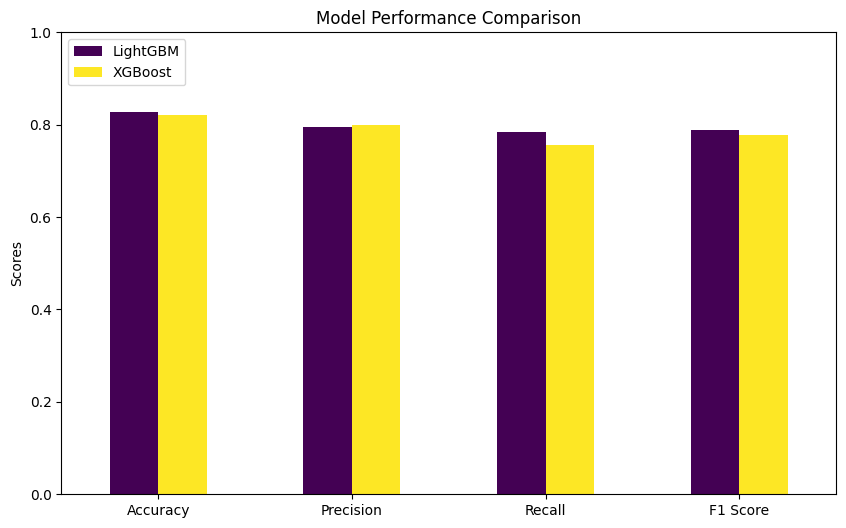

           LightGBM   XGBoost
Accuracy   0.826816  0.821229
Precision  0.794521  0.800000
Recall     0.783784  0.756757
F1 Score   0.789116  0.777778


In [4]:

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Features and target
X = train_df.drop(columns=['Survived', 'Name', 'Ticket', 'PassengerId'])
y = train_df['Survived']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
lgb_model = lgb.LGBMClassifier()
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Train models
lgb_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# Predictions
lgb_pred = lgb_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

# Evaluation metrics
def get_metrics(y_test, y_pred):
    return {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred)
    }

lgb_metrics = get_metrics(y_test, lgb_pred)
xgb_metrics = get_metrics(y_test, xgb_pred)

# Comparative Analysis
metrics_df = pd.DataFrame({'LightGBM': lgb_metrics, 'XGBoost': xgb_metrics})

# Visualize the results
metrics_df.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title('Model Performance Comparison')
plt.ylabel('Scores')
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.legend(loc='upper left')
plt.show()

# Print metrics
print(metrics_df)
